In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import iminuit as minuit


import scipy
from matplotlib import gridspec

from scipy.signal import find_peaks
from sklearn.linear_model import LinearRegression
from scipy import stats
from scipy import optimize
from scipy.optimize import curve_fit
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import chisquare
from iminuit import cost
from scipy.stats import chi2
import warnings
warnings.filterwarnings('ignore')



In [6]:
### reading in data and calibrating
def readDS(filename, calibration_file):
   # print('File:', filename)
    comments = []
    with open(filename) as ff:
        lines = ff.readlines()
        start = pd.to_datetime(lines[14][6:-1])
        commentlength = int(lines[17][-3:-1])
      #  print(commentlength, start)
        for i in range(0,commentlength):
            comments.append(lines[19+i][9:-1])
       # print(comments)
    
    """ read datafile store as dataframe name temp """
    temp = pd.read_csv(filename, sep = '\t', skiprows = 19+commentlength, header = None,usecols = np.arange(0,8))
    temp.columns = ['name', 'det', 't', 'evt_num', 'x', 'y', 'ychan', 'xchan']
    temp = temp.query('det == "DS"')

    """ look for events where more than one strip was hit"""
    temp['nX'] = temp.groupby(['t', 'xchan'])['t'].transform('count')
    temp['nY'] = temp.groupby(['t', 'ychan'])['t'].transform('count')
    #print ('--------before--------')
    #print (temp)

    #apply the calibration file
    #pull the three columns of the cali file, and merge with temp
    """ convert channel number to energy. Using a linear calibration of E = (m*(chan - b) + 89.2)/1.005  """
    """ The factors of 89.2 and 1.005 are just offsets to account for detector dead layer energy loss """
    temp2 = pd.merge(temp, calibration_file[['x', 'mx', 'xint']], on = 'x', how = 'left')
    temp2 = pd.merge(temp2, calibration_file[['y', 'my', 'yint']], on = 'y', how = 'left')
    temp2['xstripE'] = temp2['mx'] * temp2['xchan'] + temp2['xint']
    temp2['ystripE'] = temp2['my'] * temp2['ychan'] + temp2['yint']
    #print ('--------after calibration is applied')
    #print (temp2)



    """ make a flag to identify differences in strips between higher-multiplicity events """
    temp2['xdiff'] = temp2.groupby(['t'])['x'].transform('max') - temp2.groupby(['t'])['x'].transform('min')
    temp2['ydiff'] = temp2.groupby(['t'])['y'].transform('max') - temp2.groupby(['t'])['y'].transform('min')
    
    """ get energy sums for events """
    temp2['xE']= temp2.groupby(['t','nX'])['xstripE'].transform('sum')/(temp2['nX'])
    temp2['yE'] = temp2.groupby(['t', 'nY'])['ystripE'].transform('sum')/temp2['nY']

    """ query out events with multiplicity > 2 and mult = 2 events which aren't in neighbouring strips"""
    temp3 = temp2.query('xdiff < 2 and ydiff < 2')
    
    """ another flag to keep the lowest energy x,y hit of mult = 2 events """
    temp3 = temp3.sort_values(by = ['t','xchan','ychan'], ascending = [True,False,False])
    temp3['xdup'] = temp3.duplicated(['t','xchan'], keep = 'last')#keep = 'first')
    temp3['ydup'] = temp3.duplicated(['t', 'ychan'], keep = 'last') #keep = 'first')
    temp4 = temp3.query('xdup == False and ydup == False').drop(['ychan','xchan', 'xdiff', 'ydiff', 'xdup','ydup'], axis = 1)
    
    #drop these calibration columns if not greater than 0
    """ choose which columns appear in the sorted dataframe """
    result = temp4.drop(['xstripE', 'ystripE', 'mx', 'xint', 'my', 'yint'], axis = 1).query('xE > 0 and yE > 0')
    
    filedur = max(result['t']) - min(result['t'])
    #print('This file calibrated using Edep = 1.005*Einc - 89.2 keV')
    #print('duration = %is = %.2lf min = %.2lf hr \n -----------------------------------------------------------------'%(filedur, filedur/60, filedur/3600))
    
    """ return the final dataframe and the start time from the header"""

    return result, start

### guassian fit
def onepeak(x, amp1,cen1,sigma1):
    return amp1*(np.exp((-1.0/2.0)*(((x-cen1)/sigma1)**2))) 

def twopeaks(x, amp1,cen1,sigma1, amp2,cen2,sigma2):
    return amp1*(np.exp((-1.0/2.0)*(((x-cen1)/sigma1)**2))) + amp2*(np.exp((-1.0/2.0)*(((x-cen2)/sigma2)**2)))

### reading rutherfords
def readRuth(filename, detector):
    """ print comment lines from the lmd file """
    #print('File:', filename)
    comments = []
    with open(filename) as ff:
        lines = ff.readlines()
        start = pd.to_datetime(lines[14][6:-1])
        commentlength = int(lines[17][-3:-1])
       # print(commentlength, start)
        for i in range(0,commentlength):
            comments.append(lines[19+i][9:-1])
        #print(comments)
    
    """ C1 data has a chopper flag column, DS and C2 don't """
    if detector == 'ruthE':
        temp = pd.read_csv(filename, sep = '\t', skiprows = 19+commentlength, header = None, usecols = np.arange(0,5))
        temp.columns = ['name', 'det', 't', 'evt_num', 'Ruth']
        
        
    return temp, start
def onepeak_error(x, par):
    return par[0]*(np.exp((-1.0/2.0)*(((x-par[1])/par[2])**2))) 
def twopeaks_error(x, par):
    return par[0]*(np.exp((-1.0/2.0)*(((x-par[1])/par[2])**2))) +par[3]*(np.exp((-1.0/2.0)*(((x-par[4])/par[5])**2))) 

### f033, 254/1, no gas

<bound method NDFrame._add_numeric_operations.<locals>.max of 0          344.980908
1          345.023059
2          345.054165
3          345.054680
4          345.093900
             ...     
329269    5619.465270
329270    5619.471966
329271    5619.537932
329272    5619.618630
329273    5619.621179
Name: t, Length: 329274, dtype: float64>
<bound method NDFrame._add_numeric_operations.<locals>.max of 0            127.535483
1            127.554170
2            127.571045
3            127.617207
4            127.642122
               ...     
1437321    23108.211339
1437322    23108.217545
1437323    23108.220610
1437324    23108.270058
1437325    23108.270341
Name: t, Length: 1437326, dtype: float64>


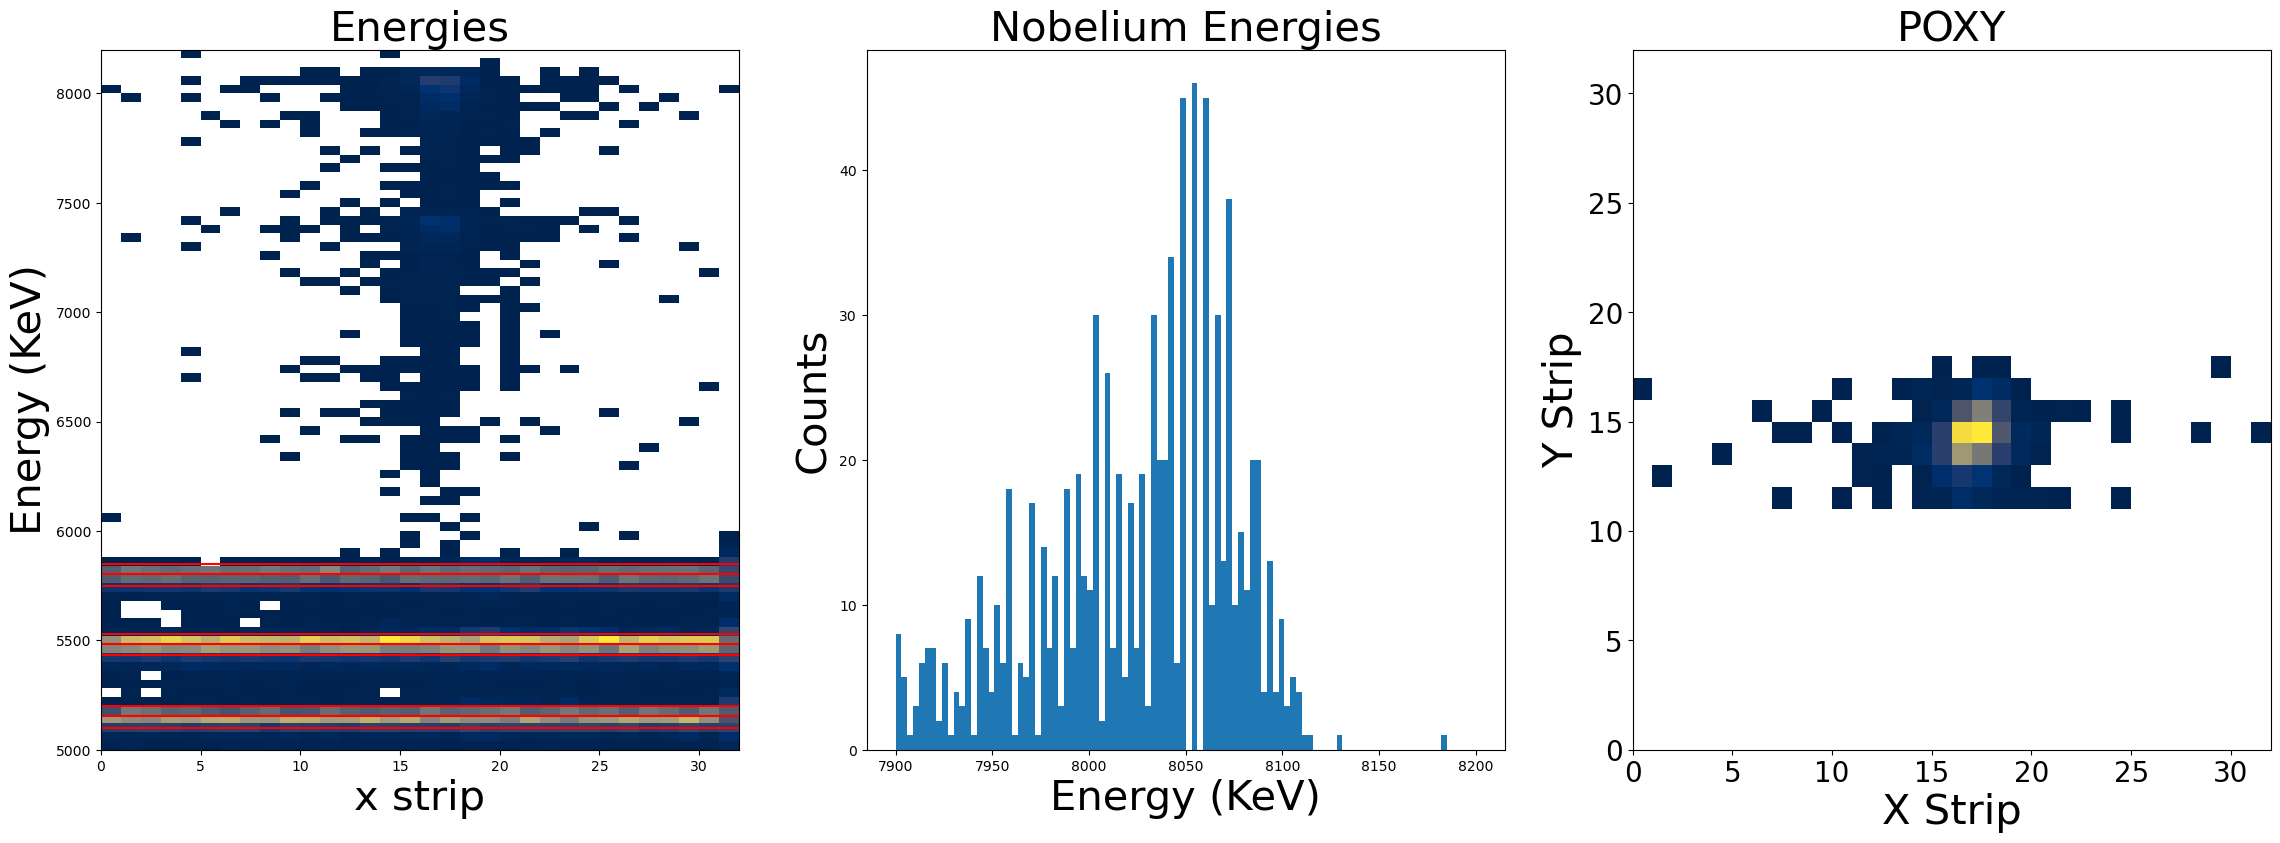

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 49.01 (chi2/ndof = 2.7)    │              Nfcn = 466              │
│ EDM = 0.000132 (Goal: 0.0002)    │            time = 0.1 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬────

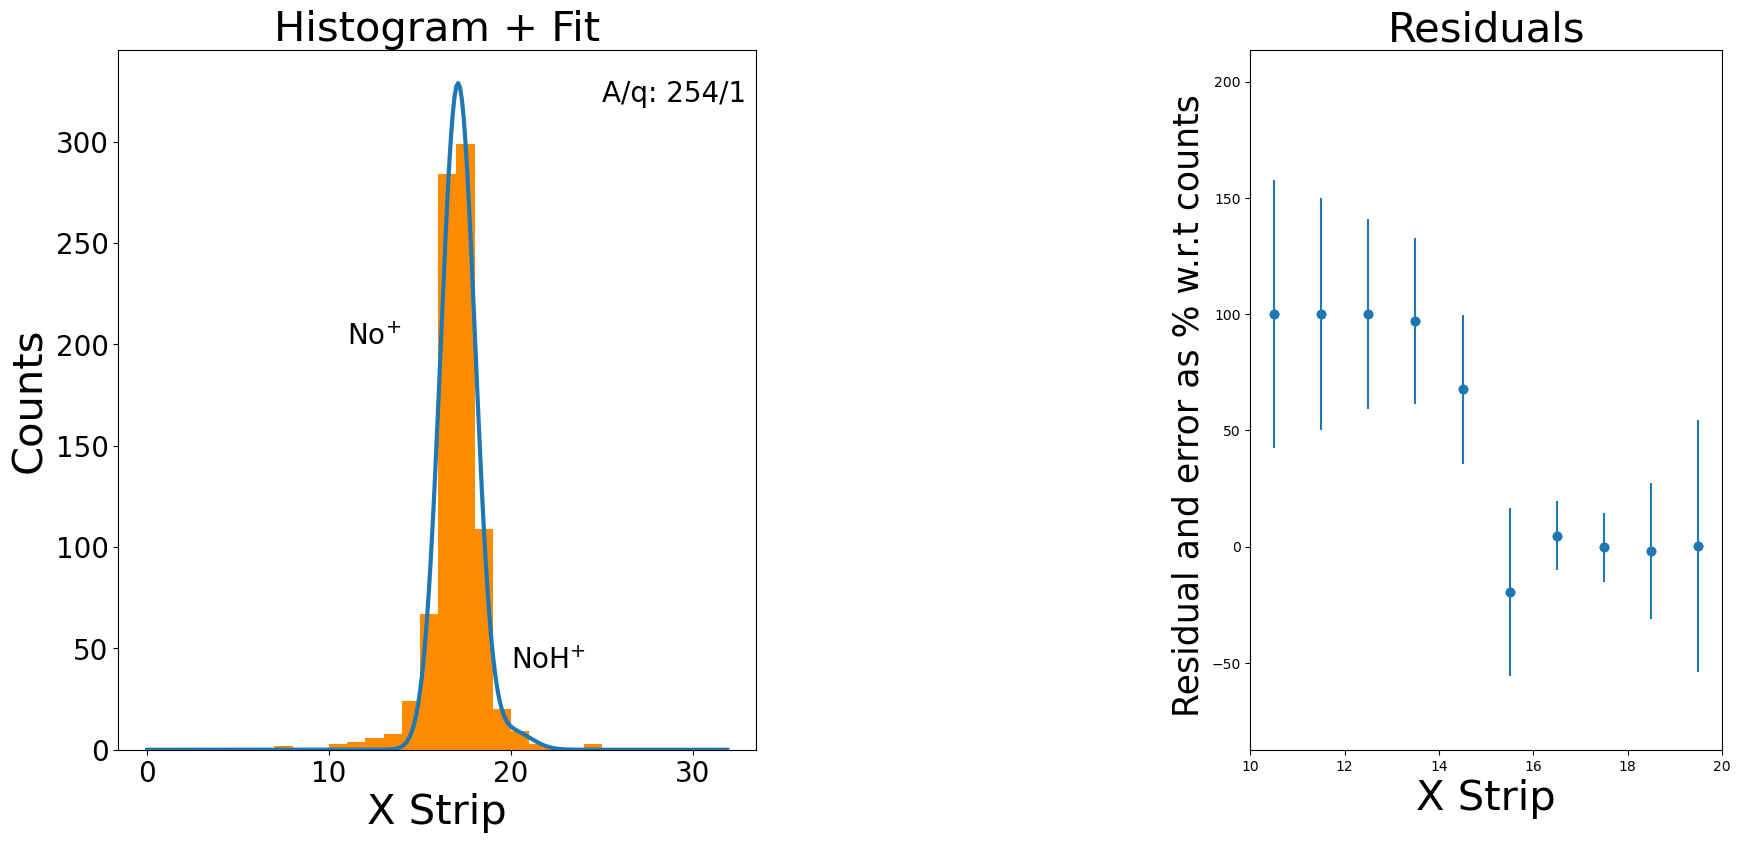

In [9]:
cal = pd.read_csv('run231_calibration_run037.txt', sep = '\t', index_col = 0)
df0_1, t0_1 = readDS('run231_033_output.txt', cal)
df0_2, t0_2 = readDS('run231_033_2_output.txt', cal)
df = pd.concat([df0_1,df0_2])

data_1 = pd.read_csv('run231_033_output.txt', sep = '\t', skiprows = 24, names = ['datafile', 'det', 't', 'evt_num', 'x', 'y', 'ychan', 'xchan','0'])
data_2 = pd.read_csv('run231_033_2_output.txt', sep = '\t', skiprows = 24, names = ['datafile', 'det', 't', 'evt_num', 'x', 'y', 'ychan', 'xchan','0'])
print (data_1['t'].max)
print (data_2['t'].max)

### checking the energies
plt.figure(figsize = (28,20))
plt.axes().set_aspect('equal')
plt.subplot(2,3,1)
plt.hist2d(df['x'], df['xE'], range = ((0,32),(5000,9000)), bins = (32,100), cmap = 'cividis', cmin = 1)
plt.xlabel('x strip', fontsize = 30)
plt.ylabel('Energy (KeV)', fontsize = 30)
plt.title("Energies", fontsize = 30)
plt.ylim(5000,8200)
plt.axhline(5156, color = "red")
plt.axhline(5200, color = "red")
plt.axhline(5100, color = "red")
plt.axhline(5485, color = "red")
plt.axhline(5530, color = "red")
plt.axhline(5435, color = "red")
plt.axhline(5804, color = "red")
plt.axhline(5850, color = "red")
plt.axhline(5750, color = "red")


### Creating the gated data and bining
gates = df[(df['y'] >=11) & (df['y'] < 18) & (df['xE'] > 7900) & (df['xE']<8500)]

### Checking Nobelium Energy 
plt.subplot(2,3,2)
plt.hist(gates['xE'], bins = 100, range = (7900,8200))
plt.ylabel('Counts', fontsize = 30)
plt.xlabel('Energy (KeV)', fontsize = 30)
plt.title("Nobelium Energies", fontsize = 30)


### 2d hist
plt.subplot(2,3,3)
plt.hist2d(gates['x'], gates['y'], range = ((0,32),(0,32)), bins = (32,32), cmap = 'cividis', cmin = 1)
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Y Strip',fontsize = 30)
plt.title("POXY", fontsize = 30)
plt.show()


### histogram and fit
xbins = range(0,32)
hist= plt.hist(gates['x'], bins = xbins)
plt.close()
bins_1_= hist[1]
counts_= hist[0]
counts=counts_.astype(int)
bins_1=bins_1_.astype(int)
bins = 0.5*(bins_1[1:]+ bins_1[:-1])
bins_=np.arange(0,32,.1)
_bins=np.arange(0,32,1)
newBins_change = bins[np.where(counts != 0)]
newcounts= counts[np.where(counts!=0)]
ye = np.sqrt(newcounts)
c = cost.LeastSquares(newBins_change,newcounts,ye,twopeaks)
m= minuit.Minuit(c,250,15,1,25,18,1)
m.limits=((0,None), (16,None),(0,1),(0,None), (0,None),(0,1))
print (m.migrad())
amp_1=m.values[0]
cen_1=m.values[1]
exp_1=m.values[2]
amp_2=m.values[3]
cen_2=m.values[4]
exp_2=m.values[5]
yy= twopeaks(bins_,amp_1,cen_1,exp_1,amp_2,cen_2,exp_2)
yy_=twopeaks(newBins_change,amp_1,cen_1,exp_1,amp_2,cen_2,exp_2)
#print(yy)
#print(yy)
plt.figure(figsize = (28,20))
plt.axes().set_aspect('equal')
plt.subplot(2,3,4)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
plt.plot(bins_,yy,linewidth=3)
plt.bar(bins,counts, width=1.0,color='darkorange')
plt.tick_params(axis='both', labelsize=20)
plt.title("Histogram + Fit", fontsize = 30)
#plt.axvline(16.12,ymin=0, ymax=.5, linewidth= 5, color = "lightgreen",label='$^{202}$At f034')
#plt.axvline(19.4,ymin=0, ymax=.5, linewidth= 5, color = "blue",label='Disp. Line')
plt.text(25,320, "A/q: 254/1", fontsize = 20)
plt.text(11,200, "No$^{+}$", fontsize = 20)
#plt.text(11,180, "254/1", fontsize = 20)
plt.text(20,40, "NoH$^{+}$", fontsize = 20)
#plt.text(20,20, "255/1", fontsize = 20)





### defining errors, including minuit bootstrapping for gaussian fits. Includes inflating the error with reduced chi2, which is hard coded
c_= np.sqrt(newcounts)
rng = np.random.default_rng(1)
par_b = rng.multivariate_normal(m.values, m.covariance, size=1000)
y_b = [onepeak_error(newBins_change, p) for p in par_b]
error = 2.9*np.std(y_b, axis=0)
reserror= np.sqrt(c_**2+error**2)



### scatter plot with fit
plt.subplot(2,3,5)
plt.plot(bins_,yy)
plt.title("Scatter plot + fit", fontsize = 30)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
plt.scatter(newBins_change,newcounts,label='data',color='orange')
plt.errorbar(newBins_change,newcounts,yerr=c_, fmt= "o")
plt.scatter(newBins_change,yy_,label='fit',color='green')
plt.errorbar(newBins_change,yy_,yerr=error, fmt= "o")
legend = plt.legend(loc='upper right', shadow=True, fontsize='x-large')


### Residuals
residual = (newcounts - yy_)/newcounts*100
residual_errors=np.sqrt(np.sqrt(newcounts)**2+error**2)/newcounts*100
plt.subplot(2,4,7)
plt.title("Residuals", fontsize = 30)
plt.scatter(newBins_change[2:23],residual[2:23])
plt.errorbar(newBins_change[2:23],residual[2:23], yerr=residual_errors[2:23], fmt= 'o')
plt.xlim(10,20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Residual and error as % w.r.t counts ',fontsize = 25)

### How many counts in peak, area of the peak
area1_1=amp_1*exp_1/.3989
area2_1=amp_2*exp_2/.3989



### Rutherford Number, East
dfRuth_0_1, t1Ruth_0_1 = readRuth('run231_033_output_Ruth.txt', 'ruthE')
dfRuth_0_2, t1Ruth_0_2 = readRuth('run231_033_2_output_Ruth.txt', 'ruthE')
dfRuth = pd.concat([dfRuth_0_1,dfRuth_0_2])
print(" Number of Rutherfords? = %0.10f" % (len(dfRuth)))

### Counts per 1k ruth (CPR)
CPR_No_oneplus_nogas = area1_1/(len(dfRuth)/1000)
CPR_No_oneplus_nogas_hydride = area2_1/(len(dfRuth)/1000)


error_Ruth=np.sqrt(len(dfRuth))
error_CPR_No_oneplus_nogas= CPR_No_oneplus_nogas*np.sqrt(1/area1_1+1/len(dfRuth))
error_CPR_No_oneplus_nogas_hydride= CPR_No_oneplus_nogas_hydride*np.sqrt(1/area2_1+1/len(dfRuth))

print(error_CPR_No_oneplus_nogas)
print (m.covariance)
print(" Counts per 1k ruth (CPR_No_oneplus_nogas) =  %0.10f (+/-) %0.10f" % (CPR_No_oneplus_nogas, error_CPR_No_oneplus_nogas))
print(" Counts per 1k ruth (CPR_No_oneplus_nogas_hydride) =  %0.10f (+/-) %0.10f" % (CPR_No_oneplus_nogas_hydride, error_CPR_No_oneplus_nogas_hydride))




# f041, 254/1, gas

<bound method NDFrame._add_numeric_operations.<locals>.max of 0             0.026276
1             0.051344
2             0.075594
3             0.080620
4             0.092552
              ...     
989666    15818.616461
989667    15818.627843
989668    15818.633654
989669    15818.637404
989670    15818.660171
Name: t, Length: 989671, dtype: float64>


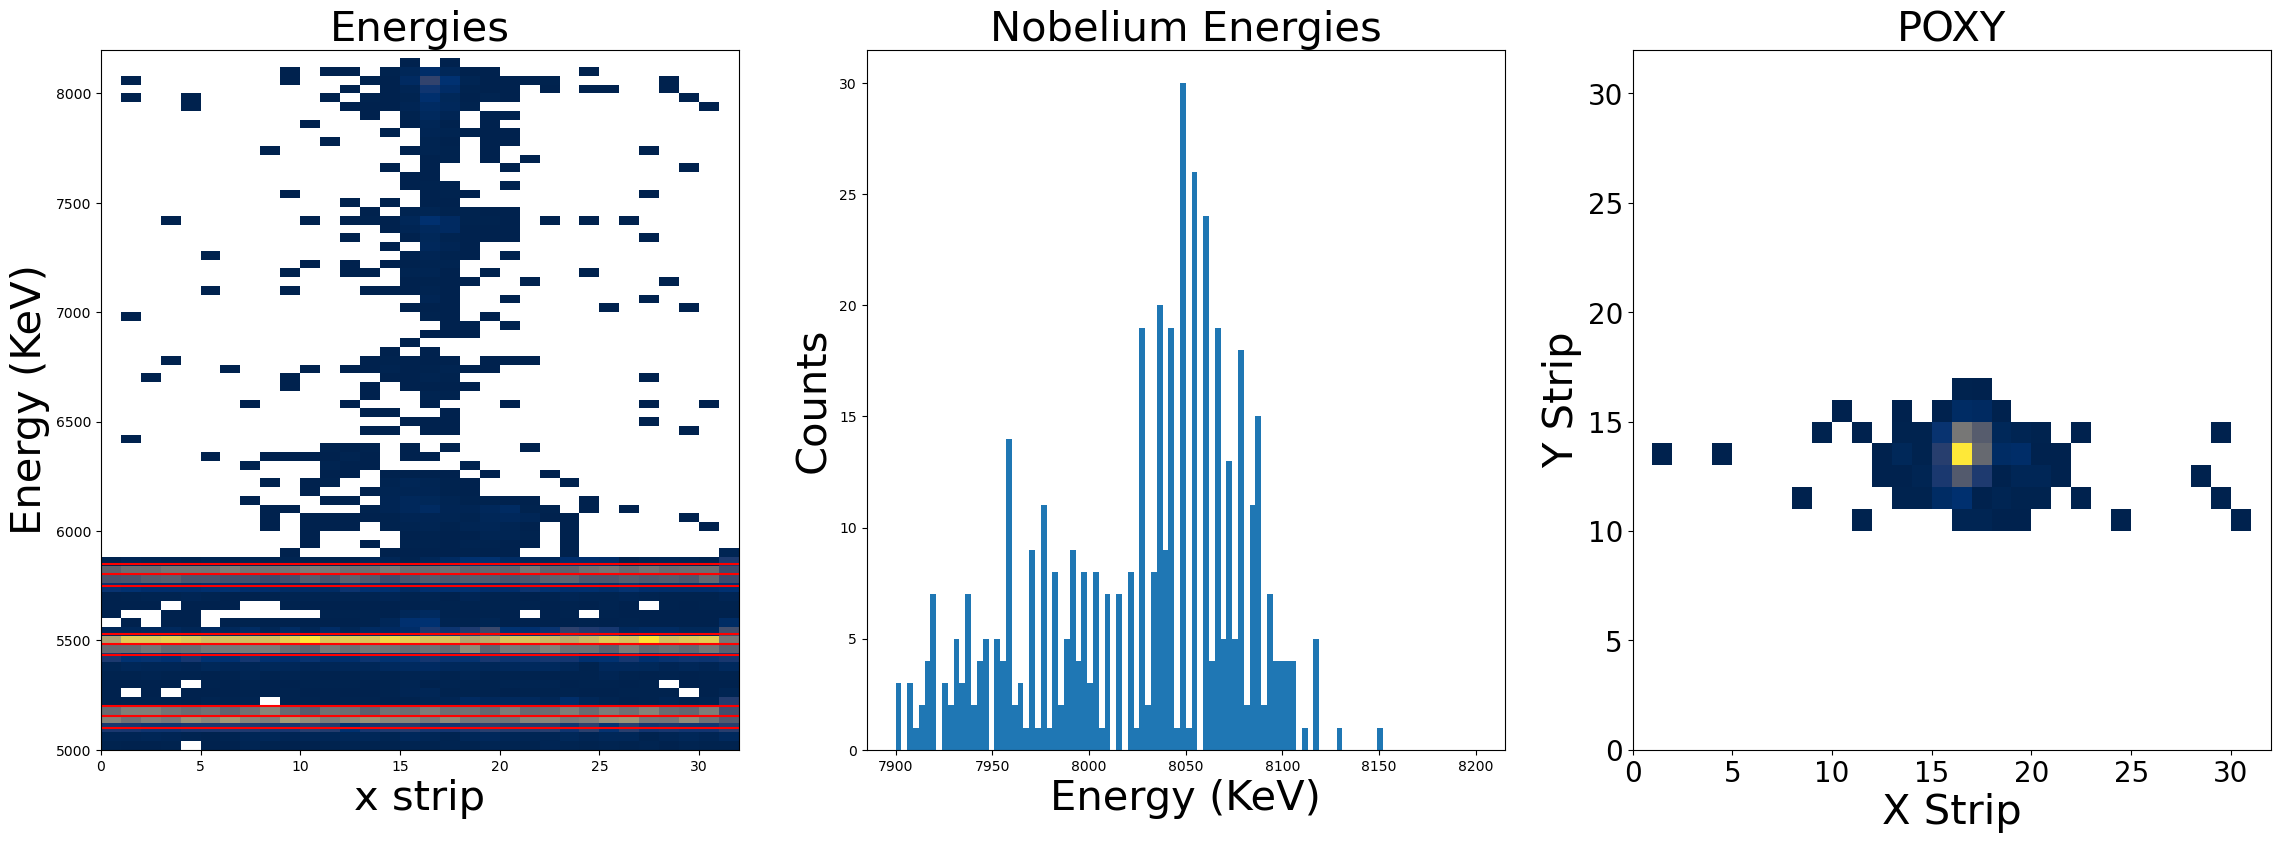

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 34.37 (chi2/ndof = 2.3)    │              Nfcn = 254              │
│ EDM = 3.61e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬────

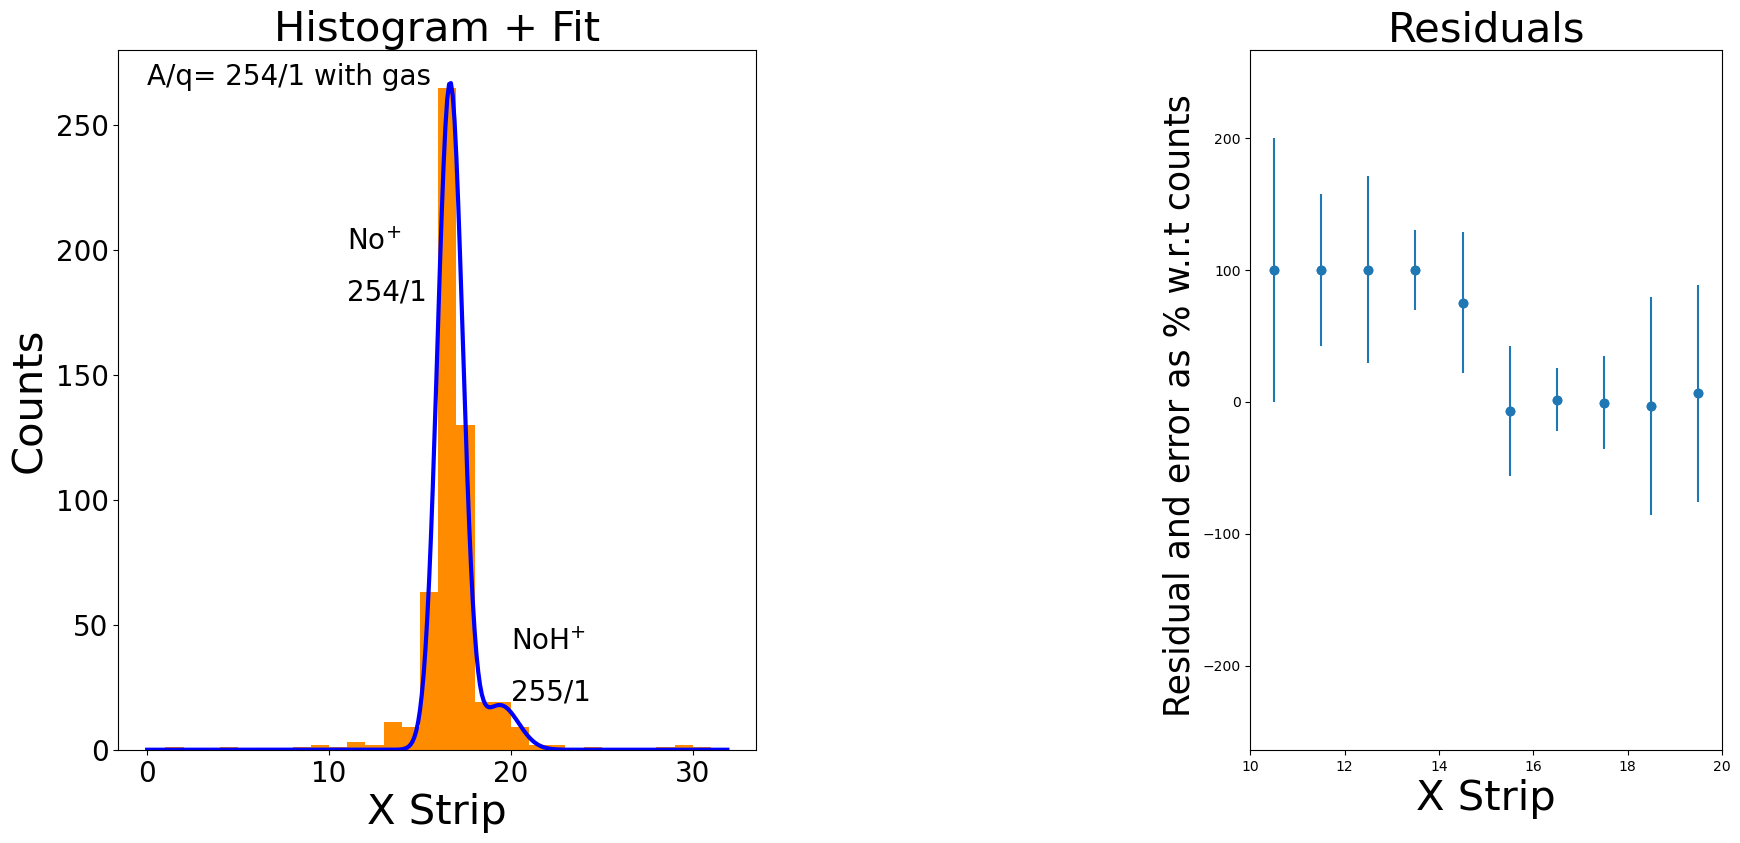

In [10]:
cal = pd.read_csv('run231_calibration_run037.txt', sep = '\t', index_col = 0)
data_1 = pd.read_csv('run231_041_output.txt', sep = '\t', skiprows = 24, names = ['datafile', 'det', 't', 'evt_num', 'x', 'y', 'ychan', 'xchan','0'])
print (data_1['t'].max)
 

df1, t1_1 = readDS('run231_041_output.txt', cal)
### checking the energies
plt.figure(figsize = (28,20))
plt.axes().set_aspect('equal')
plt.subplot(2,3,1)
plt.hist2d(df1['x'], df1['xE'], range = ((0,32),(5000,9000)), bins = (32,100), cmap = 'cividis', cmin = 1)
plt.xlabel('x strip', fontsize = 30)
plt.ylabel('Energy (KeV)', fontsize = 30)
plt.title("Energies", fontsize = 30)
plt.ylim(5000,8200)
plt.axhline(5156, color = "red")
plt.axhline(5200, color = "red")
plt.axhline(5100, color = "red")
plt.axhline(5485, color = "red")
plt.axhline(5530, color = "red")
plt.axhline(5435, color = "red")
plt.axhline(5804, color = "red")
plt.axhline(5850, color = "red")
plt.axhline(5750, color = "red")


### Creating the gated data and bining
gates_1 = df1[(df1['y'] >=10) & (df1['y'] < 17) & (df1['xE'] > 7600) & (df1['xE']<8500)]


### Checking Nobelium Energy 
plt.subplot(2,3,2)
plt.hist(gates_1['xE'], bins = 100, range = (7900,8200))
plt.ylabel('Counts', fontsize = 30)
plt.xlabel('Energy (KeV)', fontsize = 30)
plt.title("Nobelium Energies", fontsize = 30)



### 2d hist
plt.subplot(2,3,3)
plt.hist2d(gates_1['x'], gates_1['y'], range = ((0,32),(0,32)), bins = (32,32), cmap = 'cividis', cmin = 1)
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Y Strip',fontsize = 30)
plt.title("POXY", fontsize = 30)
plt.show()


### histogram and fit
xbins = range(0,32)
hist= plt.hist(gates_1['x'], bins = xbins)
plt.close()
bins_1_= hist[1]
counts_= hist[0]
counts=counts_.astype(int)
bins_1=bins_1_.astype(int)
bins = 0.5*(bins_1[1:]+ bins_1[:-1])
bins_=np.arange(0,32,.1)
_bins=np.arange(0,32,1)
newBins_change = bins[np.where(counts != 0)]
newcounts= counts[np.where(counts!=0)]
ye = np.sqrt(newcounts)
c = cost.LeastSquares(newBins_change,newcounts,ye,twopeaks)
m= minuit.Minuit(c,250,15,1,25,18,1)
m.limits=((0,None), (None,None),(0,1),(0,None), (18.8,19.9),(0.9,2))
print (m.migrad())
amp_1=m.values[0]
cen_1=m.values[1]
exp_1=m.values[2]
amp_2=m.values[3]
cen_2=m.values[4]
exp_2=m.values[5]
yy= twopeaks(bins_,amp_1,cen_1,exp_1,amp_2,cen_2,exp_2)
yy_=twopeaks(newBins_change,amp_1,cen_1,exp_1,amp_2,cen_2,exp_2)
#print(yy)
plt.figure(figsize = (28,20))
plt.axes().set_aspect('equal')
plt.subplot(2,3,4)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
plt.plot(bins_,yy,linewidth = 3, color = 'blue')
plt.bar(bins,counts, width=1.0,color='darkorange')
plt.tick_params(axis='both', labelsize=20)
plt.title("Histogram + Fit", fontsize = 30)
#plt.axvline(15.88,ymin=0, ymax=.5, linewidth= 5, color = "lightgreen",label='$^{202}$At f037')
#plt.axvline(19.01,ymin=0, ymax=.5, linewidth= 5, color = "blue",label='$^{202}$At f037')
plt.text(0,266, "A/q= 254/1 with gas", fontsize = 20)
plt.text(11,200, "No$^{+}$", fontsize = 20)
plt.text(11,180, "254/1", fontsize = 20)
plt.text(20,40, "NoH$^{+}$", fontsize = 20)
plt.text(20,20, "255/1", fontsize = 20)

### defining errors, including minuit bootstrapping for gaussian fits. Includes inflating the error with reduced chi2, which is hard coded
c_= np.sqrt(newcounts)
rng = np.random.default_rng(1)
par_b = rng.multivariate_normal(m.values, m.covariance, size=1000)
y_b = [twopeaks_error(newBins_change, p) for p in par_b]
error = 3.7*np.std(y_b, axis=0)
reserror= np.sqrt(c_**2+error**2)


### scatter plot with fit
plt.subplot(2,3,5)
plt.plot(bins_,yy)
c_= np.sqrt(newcounts)
plt.title("Scatter plot + fit", fontsize = 30)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
plt.scatter(newBins_change,newcounts,label='data',color='orange')
plt.errorbar(newBins_change,newcounts,yerr=c_, fmt= "o")
plt.scatter(newBins_change,yy_,label='fit',color='green')
plt.errorbar(newBins_change,yy_,yerr=error, fmt= "o")

### Residuals
residual = (newcounts - yy_)/newcounts*100
residual_errors=np.sqrt(np.sqrt(newcounts)**2+error**2)/newcounts*100
plt.subplot(2,4,7)
plt.title("Residuals", fontsize = 30)
plt.scatter(newBins_change[2:23],residual[2:23])
plt.errorbar(newBins_change[2:23],residual[2:23], yerr=residual_errors[2:23], fmt= 'o')
plt.xlim(10,20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Residual and error as % w.r.t counts ',fontsize = 25)

### How many counts in peak, area of the peak
area1_2=amp_1*exp_1/.3989
area2_2=amp_2*exp_2/.3989




### Rutherford Number, East
dfRuth_1, t1Ruth_1 = readRuth('run231_041_output_Ruth.txt', 'ruthE')
print(" Number of Rutherfords? = %0.10f" % (len(dfRuth_1)))

### Counts per 1k ruth (CPR)
CPR_No_oneplus_gas = area1_2/len(dfRuth_1)*1000
print(" Counts per 1k ruth (CPR_No_oneplus_gas) = %0.10f" % (CPR_No_oneplus_gas))

error_Ruth_1=np.sqrt(len(dfRuth_1))
error_CPR_No_oneplus_gas= CPR_No_oneplus_gas*np.sqrt(1/area1_2+1/len(dfRuth_1))
print(error_CPR_No_oneplus_gas)

area_Hydride=(area2_2)/len(dfRuth_1)*1000
error_CPR_hyrdie= area_Hydride*np.sqrt(1/area2_2+1/len(dfRuth_1))

print(" Counts per 1k ruth (area_Hydride) =  %0.10f (+/-) %0.10f" % (area_Hydride,error_CPR_hyrdie))
print(" Counts per 1k ruth (CPR_No_oneplus_gas) = %0.10f (+/-) %0.10f" % (CPR_No_oneplus_gas,error_CPR_No_oneplus_gas))





# No2+, no gas, f052

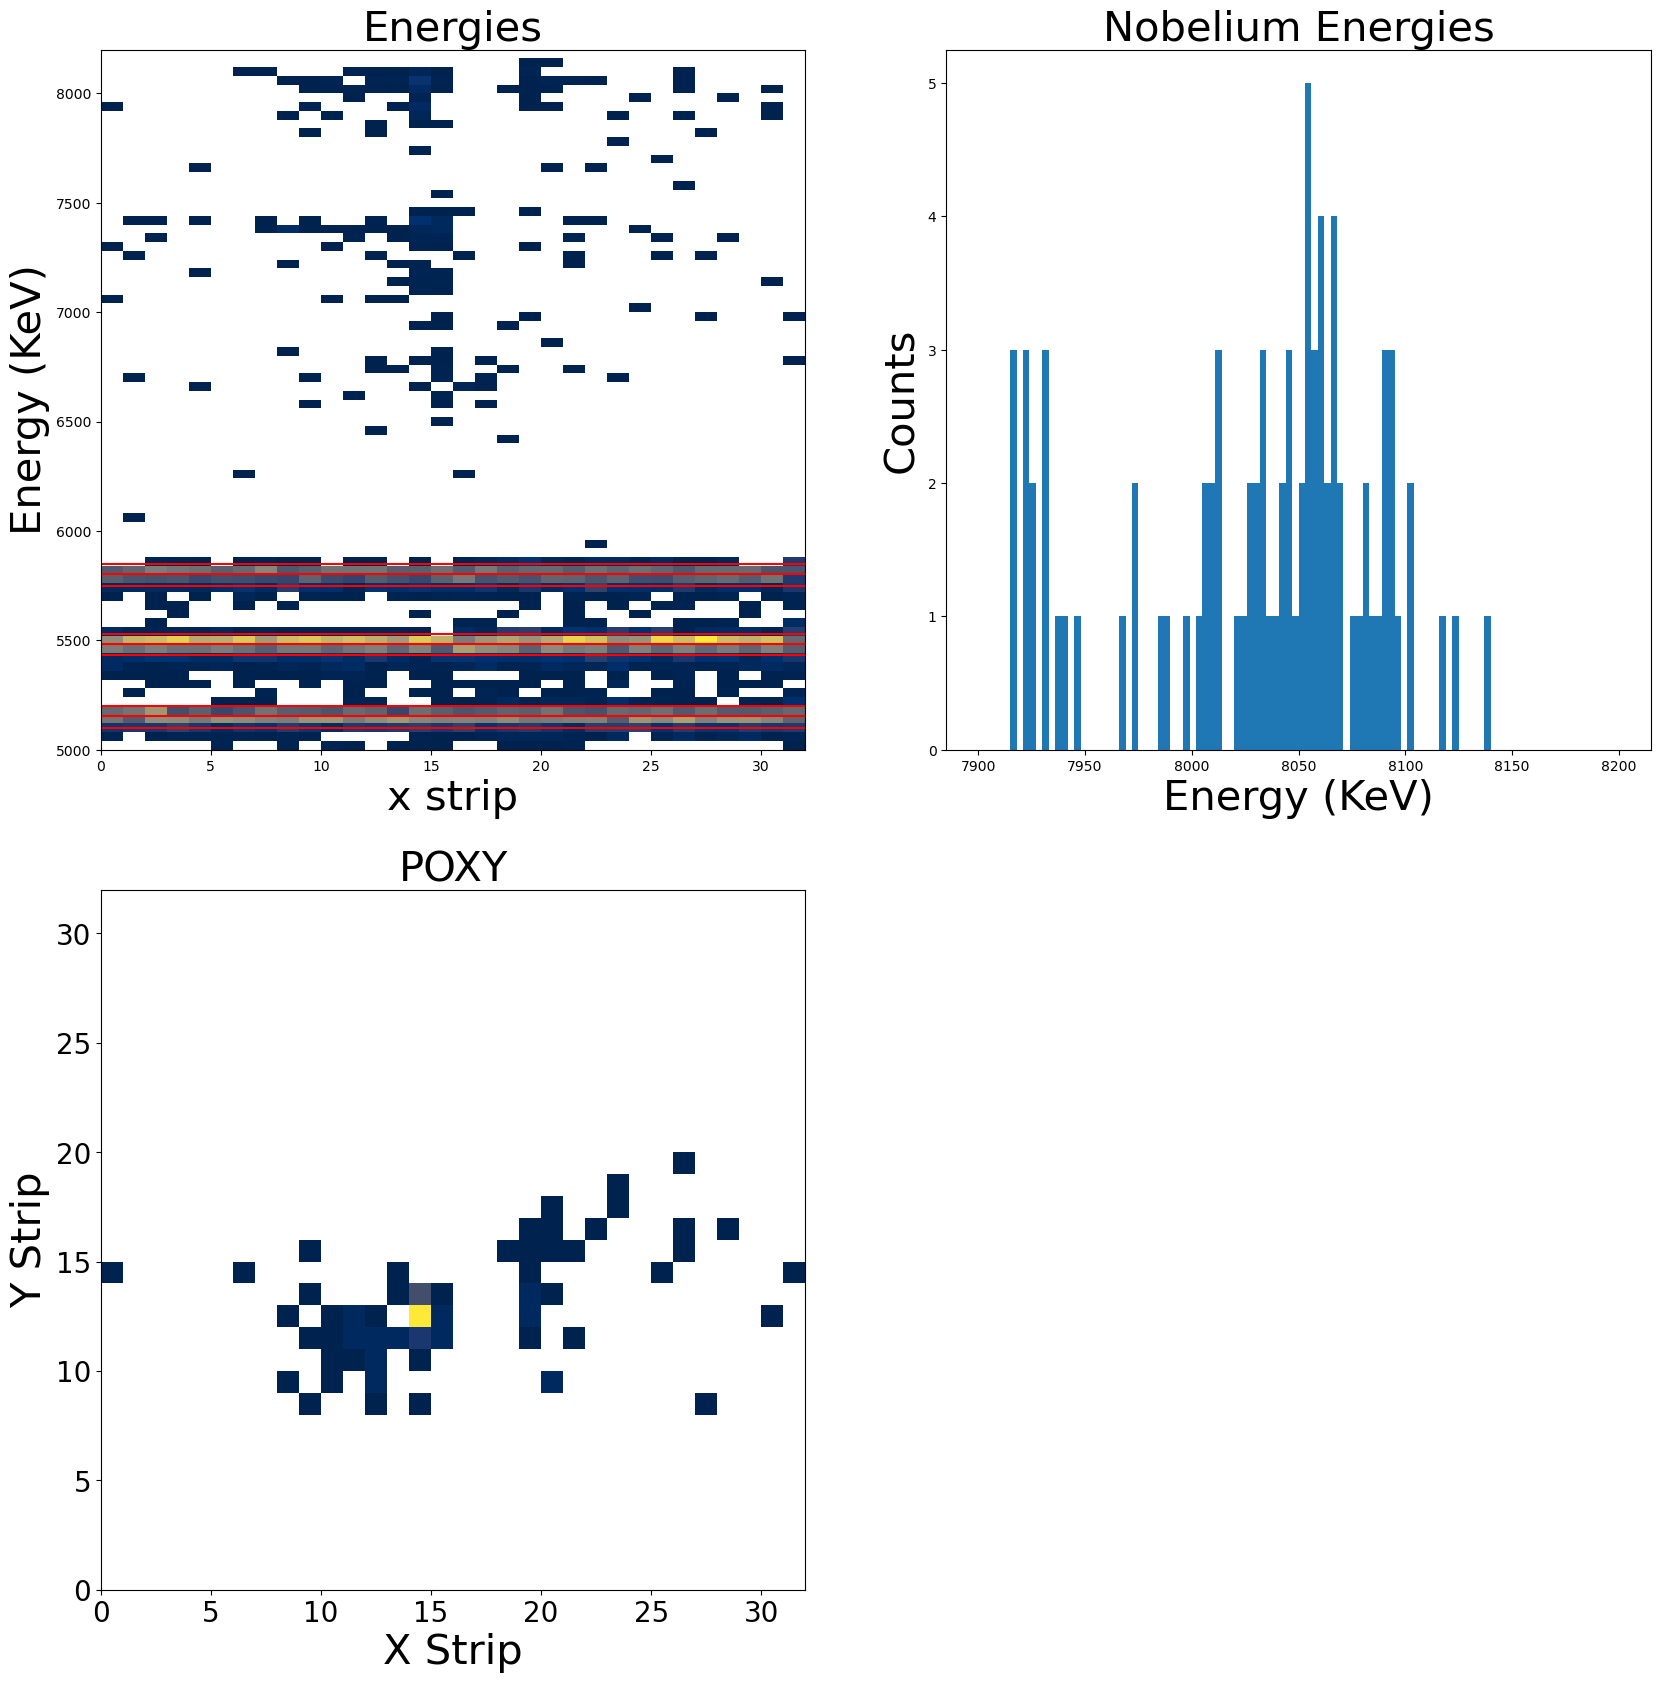

100
 Number of Rutherfords? = 36622.0000000000
 Counts per 1k ruth (CPR_No_twoplus_nogas)= 2.7305990934
0.27343246376375274


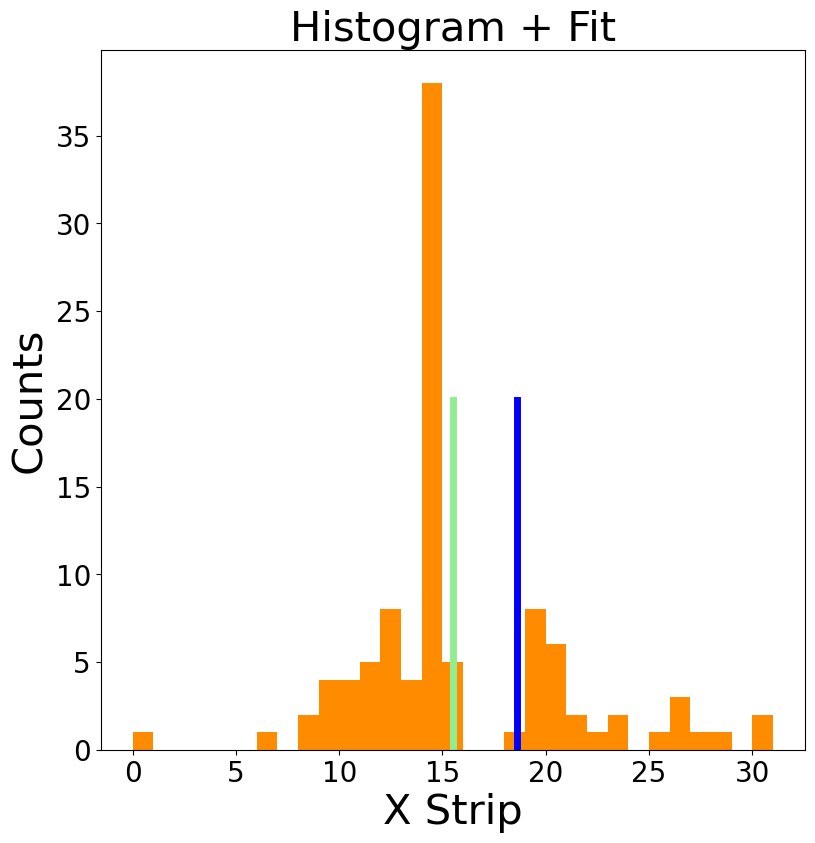

In [12]:
cal = pd.read_csv('run231_calibration_run055.txt', sep = '\t', index_col = 0)

df2, t1_2 = readDS('run231_052_output.txt', cal)
### checking the energies
plt.figure(figsize = (20,20))
plt.axes().set_aspect('equal')
plt.subplot(2,2,1)
plt.hist2d(df2['x'], df2['xE'], range = ((0,32),(5000,9000)), bins = (32,100), cmap = 'cividis', cmin = 1)
plt.xlabel('x strip', fontsize = 30)
plt.ylabel('Energy (KeV)', fontsize = 30)
plt.title("Energies", fontsize = 30)
plt.ylim(5000,8200)
plt.axhline(5156, color = "red")
plt.axhline(5200, color = "red")
plt.axhline(5100, color = "red")
plt.axhline(5485, color = "red")
plt.axhline(5530, color = "red")
plt.axhline(5435, color = "red")
plt.axhline(5804, color = "red")
plt.axhline(5850, color = "red")
plt.axhline(5750, color = "red")


### Creating the gated data and bining
gates_2 = df2[(df2['y'] >=7) & (df2['y'] < 21) & (df2['xE'] > 7700) & (df2['xE']<8400)]


### Checking Nobelium Energy 
plt.subplot(2,2,2)
plt.hist(gates_2['xE'], bins = 100, range = (7900,8200))
plt.ylabel('Counts', fontsize = 30)
plt.xlabel('Energy (KeV)', fontsize = 30)
plt.title("Nobelium Energies", fontsize = 30)


### 2d hist
plt.subplot(2,2,3)
plt.hist2d(gates_2['x'], gates_2['y'], range = ((0,32),(0,32)), bins = (32,32), cmap = 'cividis', cmin = 1)
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Y Strip',fontsize = 30)
plt.title("POXY", fontsize = 30)
plt.show()


### histogram
xbins = range(0,32)
hist= plt.hist(gates_2['x'], bins = xbins)
plt.close()
bins_1_= hist[1]
counts_= hist[0]
counts=counts_.astype(int)
bins_1=bins_1_.astype(int)
bins = 0.5*(bins_1[1:]+ bins_1[:-1])
bins_=np.arange(0,32,.1)
_bins=np.arange(0,32,1)
newBins_change = bins[np.where(counts != 0)]
newcounts= counts[np.where(counts!=0)]
plt.figure(figsize = (20,20))
plt.axes().set_aspect('equal')
#print(yy)
plt.subplot(2,2,4)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
#plt.plot(bins_,yy,linewidth = 3, color = 'blue')
plt.bar(bins,counts, width=1.0,color='darkorange')
plt.tick_params(axis='both', labelsize=20)
plt.title("Histogram + Fit", fontsize = 30)
plt.axvline(15.5,ymin=0, ymax=.5, linewidth= 5, color = "lightgreen",label='$^{202}$At f055')
plt.axvline(18.6,ymin=0, ymax=.5, linewidth= 5, color = "blue",label='Disp.Line f055')



### How many counts in peak, area of the peak
area1_3=sum(newcounts)
print (area1_3)


### Rutherford Number, East
dfRuth_2, t1Ruth_2 = readRuth('run231_052_output_Ruth.txt', 'ruthE')
print(" Number of Rutherfords? = %0.10f" % (len(dfRuth_2)))

### Counts per 1k ruth (CPR)
CPR_No_twoplus_nogas = area1_3/len(dfRuth_2)*1000
print(" Counts per 1k ruth (CPR_No_twoplus_nogas)= %0.10f" % (CPR_No_twoplus_nogas))

error_Ruth_2=np.sqrt(len(dfRuth_2))
error_CPR_No_twoplus_nogas= CPR_No_twoplus_nogas*np.sqrt(1/area1_3+1/len(dfRuth_2))
print(error_CPR_No_twoplus_nogas)



# 254/2 with gas, f074

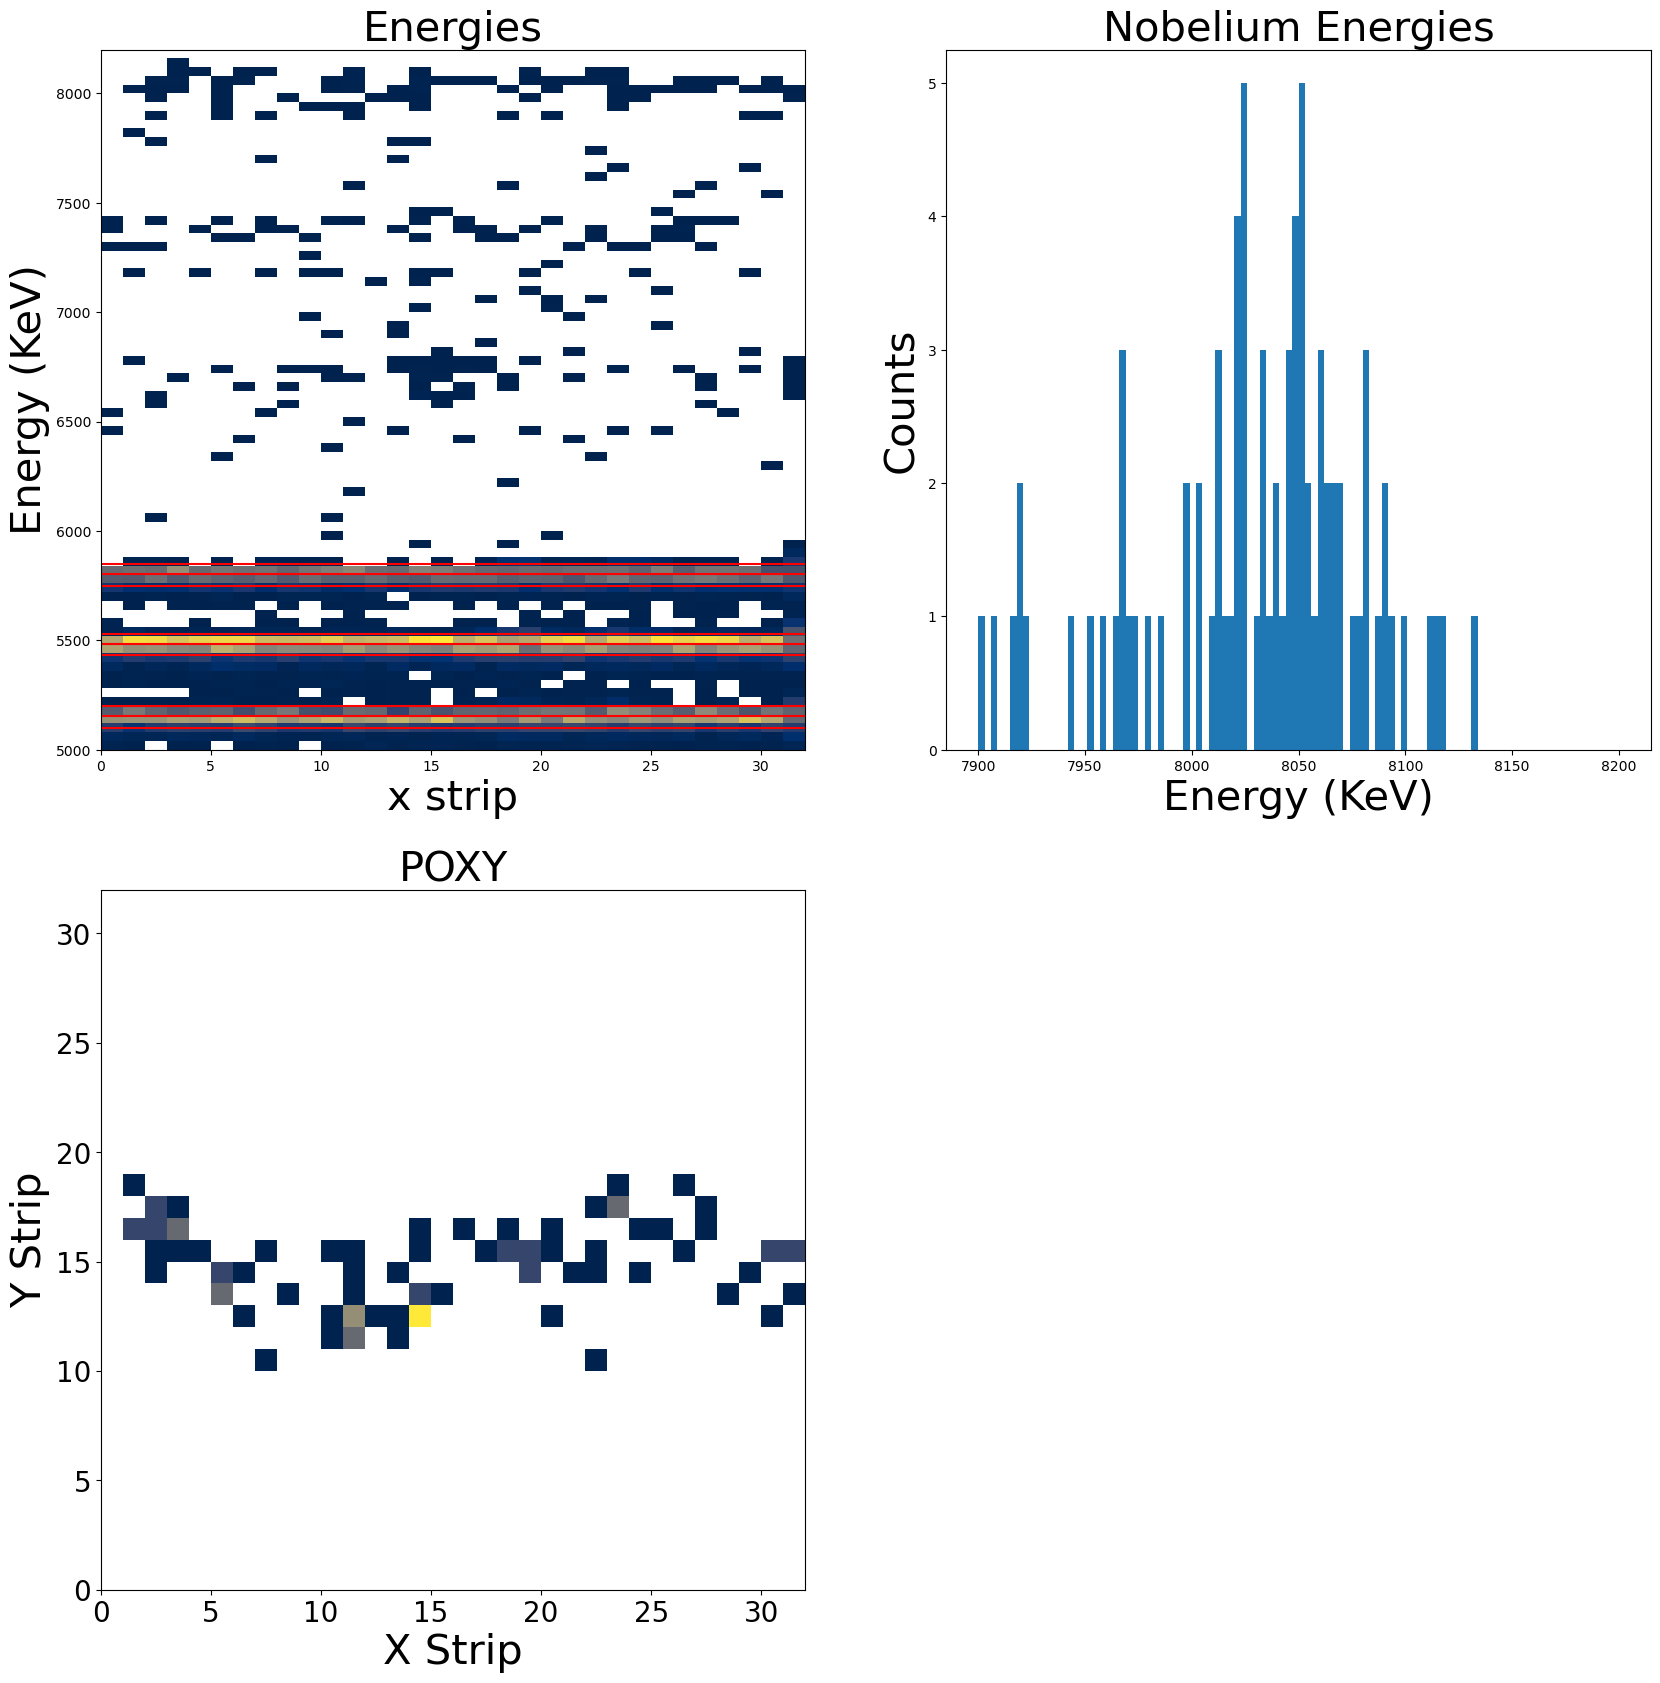

 Number of Counts? = 89.0000000000
 Number of Rutherfords? = 79512.0000000000
 Counts per 1k ruth (CPR_No_twoplus_gas)= 1.1193279002
0.11871490485153177


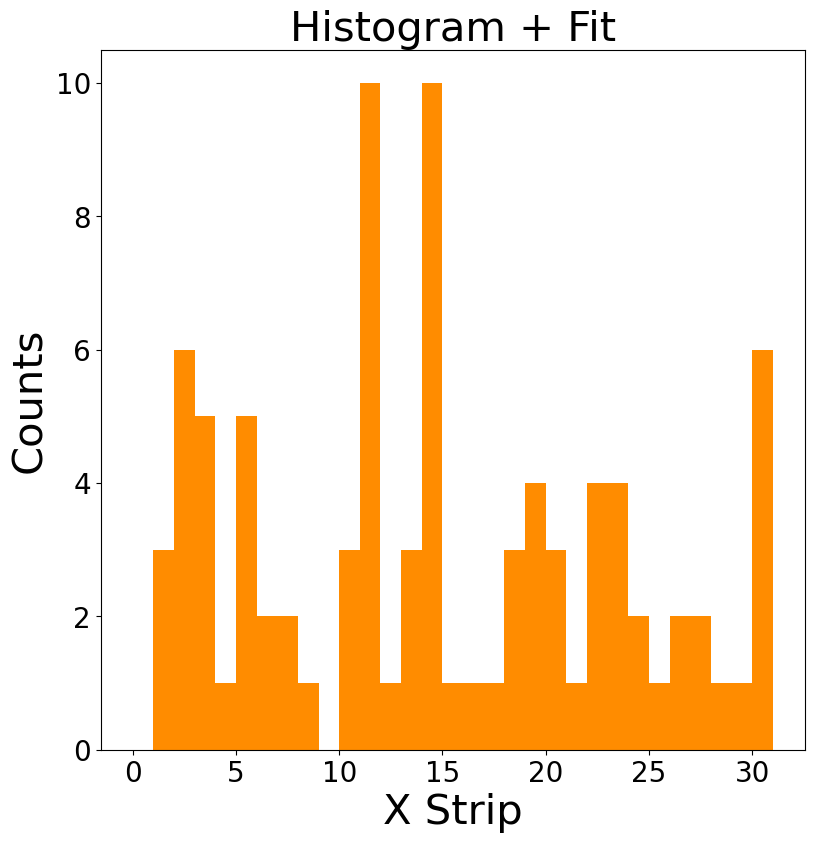

In [13]:
cal = pd.read_csv('run231_calibration_run055.txt', sep = '\t', index_col = 0)

df3, t1_3 = readDS('run231_074_output.txt', cal)
### checking the energies
plt.figure(figsize = (20,20))
plt.axes().set_aspect('equal')
plt.subplot(2,2,1)
plt.hist2d(df3['x'], df3['xE'], range = ((0,32),(5000,9000)), bins = (32,100), cmap = 'cividis', cmin = 1)
plt.xlabel('x strip', fontsize = 30)
plt.ylabel('Energy (KeV)', fontsize = 30)
plt.title("Energies", fontsize = 30)
plt.ylim(5000,8200)
plt.axhline(5156, color = "red")
plt.axhline(5200, color = "red")
plt.axhline(5100, color = "red")
plt.axhline(5485, color = "red")
plt.axhline(5530, color = "red")
plt.axhline(5435, color = "red")
plt.axhline(5804, color = "red")
plt.axhline(5850, color = "red")
plt.axhline(5750, color = "red")


### Creating the gated data and bining
gates_3 = df3[(df3['y'] >=8) & (df3['y'] < 20) & (df3['xE'] > 7700) & (df3['xE']<8400)]


### Checking Nobelium Energy 
plt.subplot(2,2,2)
plt.hist(gates_3['xE'], bins = 100, range = (7900,8200))
plt.ylabel('Counts', fontsize = 30)
plt.xlabel('Energy (KeV)', fontsize = 30)
plt.title("Nobelium Energies", fontsize = 30)



### 2d hist
plt.subplot(2,2,3)
plt.hist2d(gates_3['x'], gates_3['y'], range = ((0,32),(0,32)), bins = (32,32), cmap = 'cividis', cmin = 1)
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Y Strip',fontsize = 30)
plt.title("POXY", fontsize = 30)
plt.show()


### histogram 
xbins = range(0,32)
hist= plt.hist(gates_3['x'], bins = xbins)
plt.close()
bins_1_= hist[1]
counts_= hist[0]
counts=counts_.astype(int)
bins_1=bins_1_.astype(int)
bins = 0.5*(bins_1[1:]+ bins_1[:-1])
bins_=np.arange(0,32,.1)
_bins=np.arange(0,32,1)
newBins_change = bins[np.where(counts != 0)]
newcounts= counts[np.where(counts!=0)]
plt.figure(figsize = (20,20))
plt.axes().set_aspect('equal')
plt.subplot(2,2,4)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
#plt.plot(bins_,yy,linewidth = 3, color = 'blue')
plt.bar(bins,counts, width=1.0,color='darkorange')
plt.tick_params(axis='both', labelsize=20)
plt.title("Histogram + Fit", fontsize = 30)

area_4=sum(newcounts)
print(" Number of Counts? = %0.10f" % (sum(newcounts)))



### Rutherford Number, East
dfRuth_3, t1Ruth_3 = readRuth('run231_074_output_Ruth.txt', 'ruthE')
print(" Number of Rutherfords? = %0.10f" % (len(dfRuth_3)))

### Counts per 1k ruth (CPR)
CPR_No_twoplus_gas = area_4/len(dfRuth_3)*1000
print(" Counts per 1k ruth (CPR_No_twoplus_gas)= %0.10f" % (CPR_No_twoplus_gas))


error_Ruth_3=np.sqrt(len(dfRuth_3))
error_CPR_No_twoplus_gas= CPR_No_twoplus_gas*np.sqrt(1/area_4+1/len(dfRuth_3))
print(error_CPR_No_twoplus_gas)

# Methide Formation

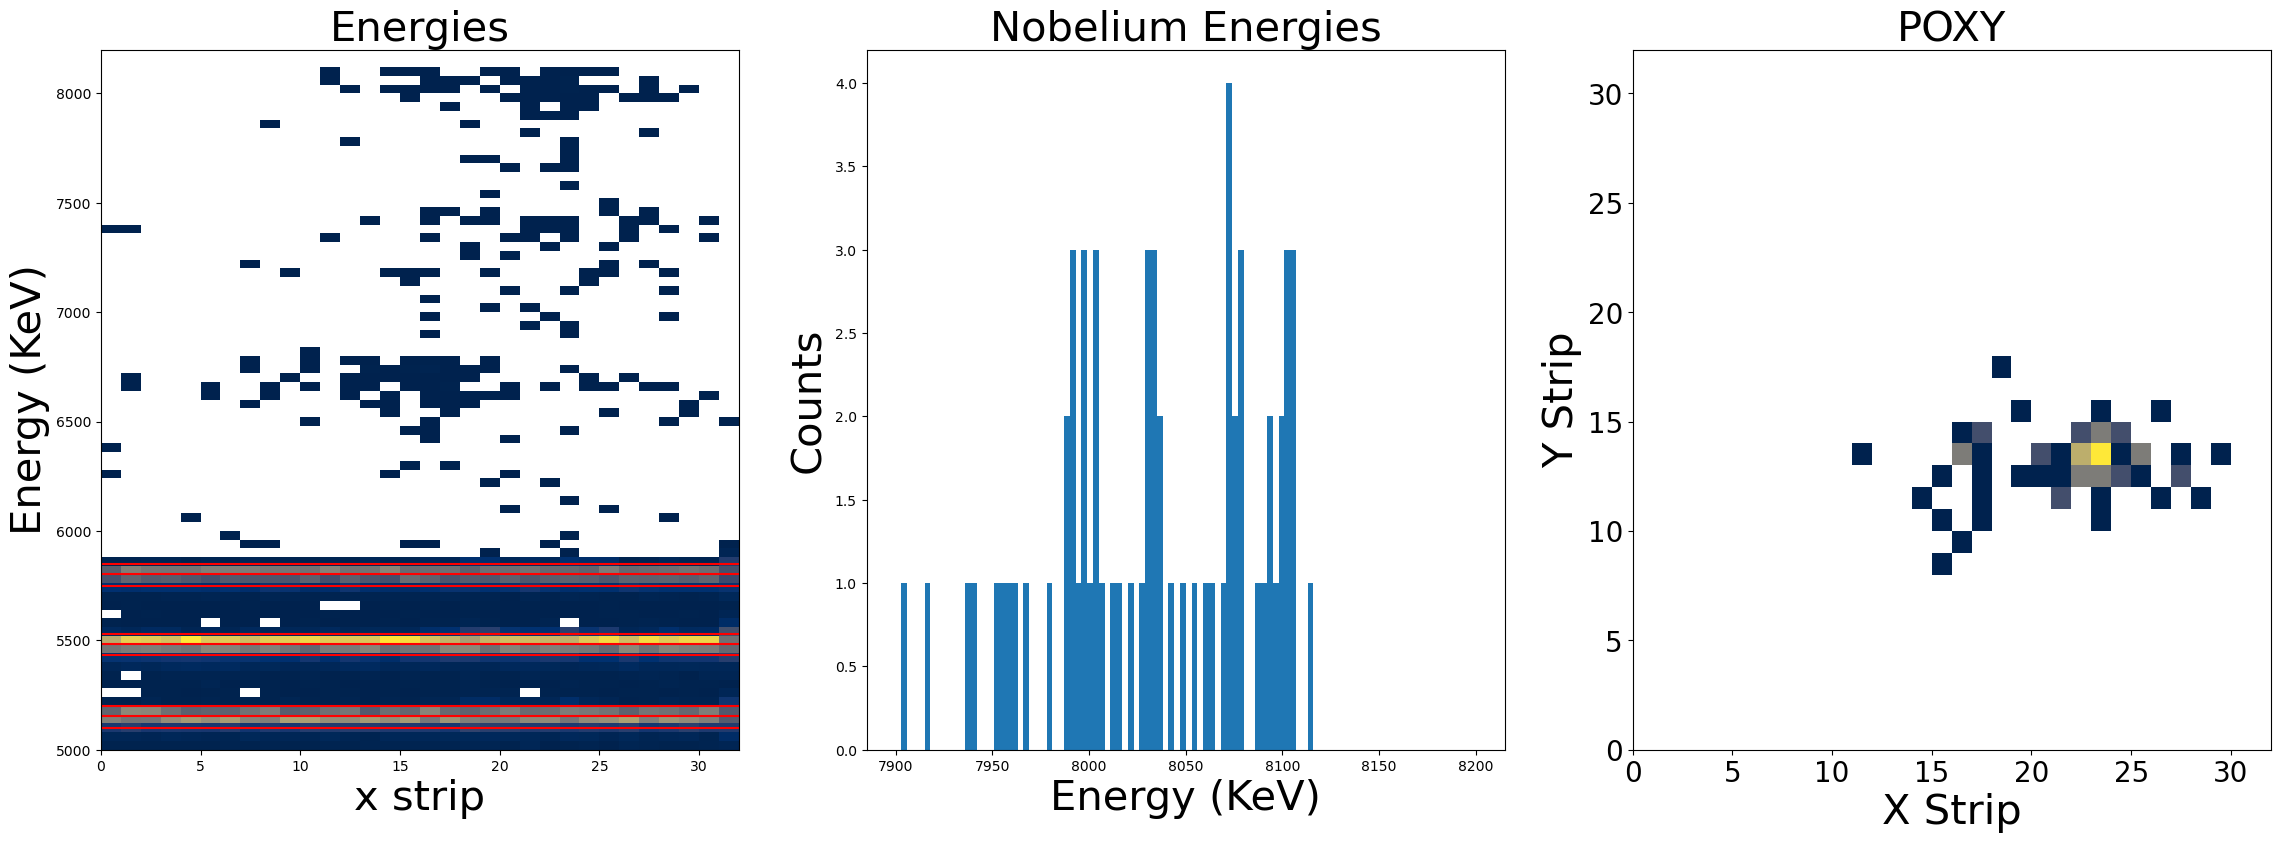

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


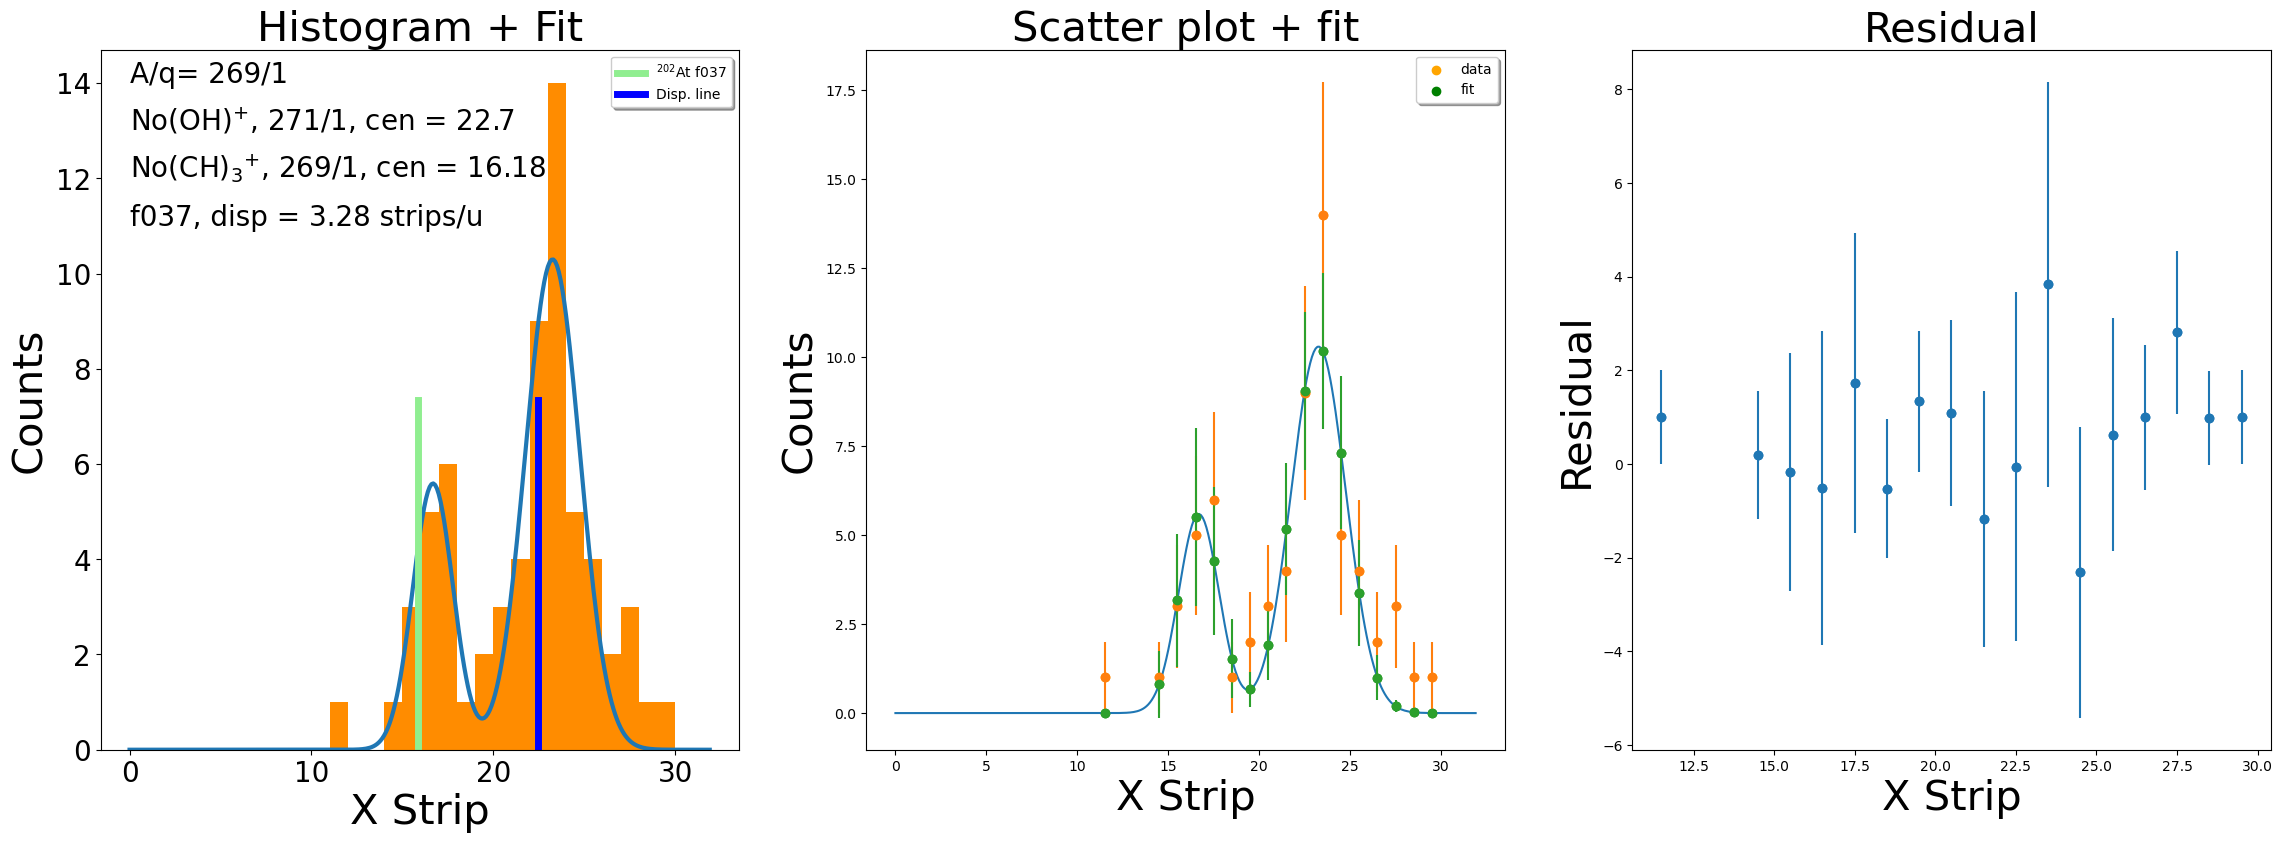

15.554308350048128
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 10.81 (chi2/ndof = 1.0)    │              Nfcn = 222              │
│ EDM = 7.32e-09 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────

In [11]:

cal = pd.read_csv('run231_calibration_run037.txt', sep = '\t', index_col = 0)


df4_1, t4_1 = readDS('run231_039_output.txt', cal)
df4_2, t4_2 = readDS('run231_039_2_output.txt', cal)
df4 = pd.concat([df4_1,df4_2])


### checking the energies
plt.figure(figsize = (28,20))
plt.axes().set_aspect('equal')
plt.subplot(2,3,1)
plt.hist2d(df4['x'], df4['xE'], range = ((0,32),(5000,9000)), bins = (32,100), cmap = 'cividis', cmin = 1)
plt.xlabel('x strip', fontsize = 30)
plt.ylabel('Energy (KeV)', fontsize = 30)
plt.title("Energies", fontsize = 30)
plt.ylim(5000,8200)
plt.axhline(5156, color = "red")
plt.axhline(5200, color = "red")
plt.axhline(5100, color = "red")
plt.axhline(5485, color = "red")
plt.axhline(5530, color = "red")
plt.axhline(5435, color = "red")
plt.axhline(5804, color = "red")
plt.axhline(5850, color = "red")
plt.axhline(5750, color = "red")


### Creating the gated data and bining
gates_4 = df4[(df4['y'] >=8) & (df4['y'] < 18) & (df4['xE'] > 7900) & (df4['xE']<8400)]



### Checking Nobelium Energy 
plt.subplot(2,3,2)
plt.hist(gates_4['xE'], bins = 100, range = (7900,8200))
plt.ylabel('Counts', fontsize = 30)
plt.xlabel('Energy (KeV)', fontsize = 30)
plt.title("Nobelium Energies", fontsize = 30)



### POXY
plt.subplot(2,3,3)
plt.hist2d(gates_4['x'], gates_4['y'], range = ((0,32),(0,32)), bins = (32,32), cmap = 'cividis', cmin = 1)
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Y Strip',fontsize = 30)
plt.title("POXY", fontsize = 30)
plt.show()


### histogram and fit
xbins = range(0,32)
hist= plt.hist(gates_4['x'], bins = xbins)
plt.close()
bins_1_= hist[1]
counts_= hist[0]
counts=counts_.astype(int)
bins_1=bins_1_.astype(int)
bins = 0.5*(bins_1[1:]+ bins_1[:-1])
bins_=np.arange(0,32,.1)
_bins=np.arange(0,32,1)
newBins_change = bins[np.where(counts != 0)]
newcounts= counts[np.where(counts!=0)]
ye = np.sqrt(newcounts)
c = cost.LeastSquares(newBins_change,newcounts,ye,twopeaks)
m= minuit.Minuit(c,6,15,1,14,24,1.2)
m.limits = [(None,None),(None,None),(0,1.5),(0,None), (0, None),(0,1.5)]
m.migrad()
amp_1=m.values[0]
cen_1=m.values[1]
exp_1=m.values[2]
amp_2=m.values[3]
cen_2=m.values[4]
exp_2=m.values[5]
yy= twopeaks(bins_,amp_1,cen_1,exp_1, amp_2,cen_2,exp_2)
yy_=twopeaks(newBins_change,amp_1,cen_1,exp_1, amp_2,cen_2,exp_2)
#print(yy)
plt.figure(figsize = (28,20))
plt.axes().set_aspect('equal')
plt.subplot(2,3,4)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
plt.plot(bins_,yy,linewidth=3)
plt.bar(bins,counts, width=1.0,color='darkorange')

plt.tick_params(axis='both', labelsize=20)
plt.title("Histogram + Fit", fontsize = 30)
plt.text(0.01,13, "No(OH)$^{+}$, 271/1, cen = 22.7", fontsize = 20)
plt.text(.01,14, "A/q= 269/1", fontsize = 20)
plt.text(0.01,12, "No(CH)$_3$$^{+}$, 269/1, cen = 16.18", fontsize = 20)
plt.text(.01,11, "f037, disp = 3.28 strips/u", fontsize = 20)
#plt.axvline(15.88,ymin=0, ymax=.5, linewidth= 5, color = "lightgreen",label='$^{202}$At f037')
#plt.axvline(22.44,ymin=0, ymax=.5, linewidth= 5, color = "blue",label='Disp. line7')

plt.legend(fontsize = 20)
plt.legend(loc='upper right', shadow=True)





### defining errors, including minuit bootstrapping for gaussian fits. Includes inflating the error with reduced chi2, which is hard coded
c_= np.sqrt(newcounts)
rng = np.random.default_rng(1)
par_b = rng.multivariate_normal(m.values, m.covariance, size=1000)
y_b = [twopeaks_error(newBins_change, p) for p in par_b]
error = np.sqrt(1.8)*np.std(y_b, axis=0)
reserror= np.sqrt(c_**2+error**2)
plt.axvline(15.88,ymin=0, ymax=.5, linewidth= 5, color = "lightgreen",label='$^{202}$At f037')
plt.axvline(22.44,ymin=0, ymax=.5, linewidth= 5, color = "blue",label='Disp. line')
plt.legend(fontsize = 20)
plt.legend(loc='upper right', shadow=True)



### scatter plot with fit
plt.subplot(2,3,5)
plt.plot(bins_,yy)
c_= np.sqrt(newcounts)
plt.title("Scatter plot + fit", fontsize = 30)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
plt.scatter(newBins_change,newcounts,label='data',color='orange')
plt.errorbar(newBins_change,newcounts,yerr=c_, fmt= "o")
plt.scatter(newBins_change,yy_,label='fit',color='green')
plt.errorbar(newBins_change,yy_,yerr=error, fmt= "o")
plt.legend(loc='upper right', shadow=True)



### Residual

residual = (newcounts - yy_)
plt.subplot(2,3,6)
plt.title("Residual", fontsize = 30)
plt.scatter(newBins_change,residual)
plt.errorbar(newBins_change,residual, yerr=reserror, fmt= 'o')
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Residual',fontsize = 30)


plt.show()
### How many counts in peak, area of the peak
area1_5=amp_1*exp_1/.3989
area2_5=amp_2*exp_2/.3989

print (area1_5)


print (m.migrad())

### Rutherford Number, East
dfRuth_4_0, t1Ruth_4_0 = readRuth('run231_039_output_Ruth.txt', 'ruthE')
dfRuth_4_1, t1Ruth_4_1 = readRuth('run231_039_2_output_Ruth.txt', 'ruthE')
dfRuth_4 = pd.concat([dfRuth_4_0,dfRuth_4_1])
print(" Number of Rutherfords? = %0.10f" % (len(dfRuth_4)))

### Counts per 1k ruth (CPR)
CPR_Methide = area1_5/len(dfRuth_4)*1000

error_Ruth_4=np.sqrt(len(dfRuth_4))
error_CPR_Methide= CPR_Methide*np.sqrt(1/area1_5+1/len(dfRuth_4))
print(" Counts per 1k ruth (CPR_Methide)= %0.10f (+/-) %0.10f" % (CPR_Methide,error_CPR_Methide))




# Calculation


In [15]:
### How much No 2+ reacted away>
No_twoplus_reacted = CPR_No_twoplus_nogas- CPR_No_twoplus_gas
error_No_twoplus_reacted = np.sqrt((error_CPR_No_twoplus_nogas)**2+(error_CPR_No_twoplus_gas)**2)
print("How many No2+ reacted = %0.10f CPR/1k (+/-) %0.10f " % (No_twoplus_reacted, error_No_twoplus_reacted))


### How much methide did we produce ?
print("how much Methide did we form = %0.10f CPR/1k (+/-) %0.10f" % (CPR_Methide, error_CPR_Methide))
 
### How efficient are we? From literautre, branching ratio = 0.25
efficiency = CPR_Methide/((No_twoplus_reacted)*.25)
error_efficiency = efficiency* np.sqrt((error_CPR_Methide/CPR_Methide)**2+(error_No_twoplus_reacted/No_twoplus_reacted)**2)
print("how efficient are we? = %0.10f CPR/1k (+/-) %0.10f" % (efficiency, error_efficiency))


### How much No2+ should be reduced due to the butane
y=CPR_No_twoplus_nogas*efficiency*0.25
error_y = y* np.sqrt((error_CPR_No_twoplus_nogas/CPR_No_twoplus_nogas)**2+(error_efficiency/efficiency)**2)
print("how many No+ should we make? = %0.10f CPR/1k (+/-) %0.10f" % (y, error_y))

### Difference between No+ with and withgas is how many were produced, include background subtraction
No_oneplus_produced=CPR_No_oneplus_gas - CPR_No_oneplus_nogas
error_No_oneplus_produced = np.sqrt(error_CPR_No_oneplus_gas**2+error_CPR_No_oneplus_nogas**2)
print("How many No+ were produced = %0.10f CPR/1k (+/-) %0.10f " % (No_oneplus_produced, error_No_oneplus_produced))

### For every Methide ion, we should see how many No+ ions? Assuming 1/1 ratio
onetoone=CPR_Methide*1/1
print("How many No+ were produced based on methide production = %0.10f CPR/1k" % (onetoone))

### What is our branching ratio experimentally?
BR= CPR_Methide/(CPR_No_twoplus_nogas*efficiency)
error_BR = BR*np.sqrt((error_CPR_Methide/CPR_Methide)**2+(error_CPR_No_twoplus_nogas/CPR_No_twoplus_nogas)**2+(error_efficiency/efficiency)**2)
print("Whats the experimental Branching Ratio= %0.10f CPR/1k (+/-) %0.10f " % (BR, error_BR))


### How much No+ are we expecting with our new branching ratio, from the No2+
No_reduced = CPR_No_twoplus_nogas*efficiency*BR
error_No_reduced=No_reduced*np.sqrt((error_CPR_No_twoplus_nogas/CPR_No_twoplus_nogas)**2*(error_efficiency/efficiency)**2+(error_BR/BR)**2)
print("How much No+ are we expecting with our new branching ratio, from the No2+= %0.10f CPR/1k (+/-) %0.10f " % (No_reduced, error_No_reduced))



How many No2+ reacted = 1.6112711932 CPR/1k (+/-) 0.2980914975 
how much Methide did we form = 0.0607944012 CPR/1k (+/-) 0.0154152806
how efficient are we? = 0.1509228279 CPR/1k (+/-) 0.0473717957
how many No+ should we make? = 0.1030274342 CPR/1k (+/-) 0.0339441447
How many No+ were produced = 0.2407843052 CPR/1k (+/-) 0.1834216214 
How many No+ were produced based on methide production = 0.0607944012 CPR/1k
Whats the experimental Branching Ratio= 0.1475199341 CPR/1k (+/-) 0.0613305701 
How much No+ are we expecting with our new branching ratio, from the No2+= 0.0607944012 CPR/1k (+/-) 0.0253470528 
